In [1]:
!pip install fsspec==2024.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.3.1 which is incompatible.


In [2]:
!pip install --upgrade torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import networkx as nx

In [22]:
class ClassicalIterativeGNN(nn.Module):
    def __init__(self, num_node_features, hidden_size, num_classes, num_iterations=5):
        super(ClassicalIterativeGNN, self).__init__()
        self.num_iterations = num_iterations


        # State update function
        self.state_update = nn.Sequential(
            nn.Linear(num_node_features + hidden_size, hidden_size),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Output function
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        num_nodes = x.size(0)

        # Initialize node states (h) with zeros, shape: (num_nodes, hidden_size)
        h = torch.zeros(num_nodes, self.state_update[0].out_features).to(x.device)

        # Iterative state update
        for _ in range(self.num_iterations):
            # Aggregate neighbor states
            neighbor_states = h[edge_index[1]]  # Neighbor states

            # If edge attributes are present, concatenate them with neighbor states
            if edge_attr is not None:
                edge_states = torch.cat([neighbor_states, edge_attr], dim=1)
            else:
                edge_states = neighbor_states  # If no edge features, only use neighbor states

            # Aggregate states from neighbors (message passing)
            aggregated = torch_geometric.utils.scatter(edge_states, edge_index[0], dim=0, dim_size=num_nodes, reduce='mean')

            # Update node states by concatenating original node features (x) with aggregated neighbor information and hidden state (h)
            node_inputs = torch.cat([x, aggregated], dim=1)  # Concatenate x (node features) and aggregated messages
            h = self.state_update(node_inputs)

        # Global mean pooling to get graph-level representation
        graph_embedding = torch_geometric.nn.global_mean_pool(h, batch)

        # Compute the output for classification
        out = self.output(graph_embedding)
        return F.log_softmax(out, dim=1)

# Basic Implementation

In [19]:
# Load dataset
dataset = TUDataset(root='PROTEINS', name='PROTEINS')

# Create DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
model = ClassicalIterativeGNN(num_node_features=dataset.num_node_features,
                              hidden_size=64,
                              num_classes=dataset.num_classes)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
print(f"Number of graphs: {len(dataset)}")
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")

# Access the first graph in the dataset
data = dataset[0]

# Print the first graph's details
print("\nDetails of the first graph:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node features: {data.x.shape}") # Node feature matrix shape
print(f"Edge features: {data.edge_attr.shape if data.edge_attr is not None else 'No edge features'}")
print(f"Graph label: {data.y}")

# You can also iterate over the first few graphs in the dataset
for i in range(5):
    print(f"\nGraph {i} details:")
    print(f"Graph {i} has {dataset[i].num_nodes} nodes and {dataset[i].num_edges} edges.")
    print(f"Node features shape: {dataset[i].x.shape}")
    print(f"Edge attributes shape: {dataset[i].edge_attr.shape if dataset[i].edge_attr is not None else 'No edge attributes'}")
    print(f"Label: {dataset[i].y}")

Number of graphs: 1113
Number of node features: 3
Number of edge features: 0
Number of classes: 2

Details of the first graph:
Number of nodes: 42
Number of edges: 162
Node features: torch.Size([42, 3])
Edge features: No edge features
Graph label: tensor([0])

Graph 0 details:
Graph 0 has 42 nodes and 162 edges.
Node features shape: torch.Size([42, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 1 details:
Graph 1 has 27 nodes and 92 edges.
Node features shape: torch.Size([27, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 2 details:
Graph 2 has 10 nodes and 34 edges.
Node features shape: torch.Size([10, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 3 details:
Graph 3 has 24 nodes and 92 edges.
Node features shape: torch.Size([24, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 4 details:
Graph 4 has 11 nodes and 42 edges.
Node features shape: torch.Size([11, 3])
Edge attributes shape: No

In [15]:
# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [16]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)


In [18]:
# Training loop
num_epochs = 100
criterion = nn.NLLLoss()

for epoch in range(num_epochs):
    loss = train(model, loader, optimizer, criterion)
    test_acc = evaluate(model, loader)
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Final evaluation
final_acc = evaluate(model, loader)
print(f'Final Accuracy: {final_acc:.4f}')

Epoch: 1, Loss: 0.6756, Test Accuracy: 0.6424
Epoch: 2, Loss: 0.6338, Test Accuracy: 0.6640
Epoch: 3, Loss: 0.6867, Test Accuracy: 0.6415
Epoch: 4, Loss: 0.6761, Test Accuracy: 0.5957
Epoch: 5, Loss: 0.6748, Test Accuracy: 0.5957
Epoch: 6, Loss: 0.6728, Test Accuracy: 0.6424
Epoch: 7, Loss: 0.6622, Test Accuracy: 0.6541
Epoch: 8, Loss: 0.6523, Test Accuracy: 0.6649
Epoch: 9, Loss: 0.6445, Test Accuracy: 0.6631
Epoch: 10, Loss: 0.6483, Test Accuracy: 0.6685
Epoch: 11, Loss: 0.6308, Test Accuracy: 0.7071
Epoch: 12, Loss: 0.6318, Test Accuracy: 0.5957
Epoch: 13, Loss: 0.6540, Test Accuracy: 0.6667
Epoch: 14, Loss: 0.6443, Test Accuracy: 0.5957
Epoch: 15, Loss: 0.6380, Test Accuracy: 0.5921
Epoch: 16, Loss: 0.6483, Test Accuracy: 0.6586
Epoch: 17, Loss: 0.6356, Test Accuracy: 0.6748
Epoch: 18, Loss: 0.6342, Test Accuracy: 0.6703
Epoch: 19, Loss: 0.6301, Test Accuracy: 0.6694
Epoch: 20, Loss: 0.6449, Test Accuracy: 0.6649
Epoch: 21, Loss: 0.6329, Test Accuracy: 0.6631
Epoch: 22, Loss: 0.630

# Hyper Parameter Experiments

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
import json
import os

In [23]:
dataset = TUDataset(root='PROTEINS', name='PROTEINS')

def run_experiment(hidden_size, num_iterations, lr, num_epochs):
    # Create DataLoader
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = ClassicalIterativeGNN(num_node_features=dataset.num_node_features,
                                  hidden_size=hidden_size,
                                  num_classes=dataset.num_classes,
                                  num_iterations=num_iterations)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define criterion
    criterion = nn.NLLLoss()

    # Initialize lists to store metrics
    train_losses = []
    test_accuracies = []
    f1_scores = []

    # Initialize TensorBoard writer
    writer = SummaryWriter(f'runs/experiment_h{hidden_size}_i{num_iterations}_lr{lr}')

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        avg_loss = total_loss / len(loader.dataset)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        predictions = []
        true_labels = []
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            predictions.extend(pred.tolist())
            true_labels.extend(data.y.tolist())

        accuracy = correct / len(loader.dataset)
        f1 = f1_score(true_labels, predictions, average='weighted')

        test_accuracies.append(accuracy)
        f1_scores.append(f1)

        print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/test', accuracy, epoch)
        writer.add_scalar('F1 Score', f1, epoch)

    writer.close()

    return train_losses, test_accuracies, f1_scores

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

Running experiment: h64_i5_lr0.01
Epoch: 1, Loss: 0.6751, Test Accuracy: 0.5957, F1 Score: 0.4448
Epoch: 2, Loss: 0.6693, Test Accuracy: 0.6415, F1 Score: 0.5540
Epoch: 3, Loss: 0.6060, Test Accuracy: 0.7125, F1 Score: 0.7137
Epoch: 4, Loss: 0.5981, Test Accuracy: 0.7224, F1 Score: 0.7163
Epoch: 5, Loss: 0.6163, Test Accuracy: 0.6748, F1 Score: 0.6297
Epoch: 6, Loss: 0.5969, Test Accuracy: 0.6757, F1 Score: 0.6786
Epoch: 7, Loss: 0.5982, Test Accuracy: 0.7197, F1 Score: 0.7195
Epoch: 8, Loss: 0.5822, Test Accuracy: 0.7197, F1 Score: 0.7078
Epoch: 9, Loss: 0.5805, Test Accuracy: 0.7376, F1 Score: 0.7316
Epoch: 10, Loss: 0.5624, Test Accuracy: 0.7251, F1 Score: 0.7226
Epoch: 11, Loss: 0.5683, Test Accuracy: 0.6837, F1 Score: 0.6470
Epoch: 12, Loss: 0.5860, Test Accuracy: 0.6972, F1 Score: 0.6678
Epoch: 13, Loss: 0.5705, Test Accuracy: 0.7125, F1 Score: 0.7131
Epoch: 14, Loss: 0.5674, Test Accuracy: 0.7367, F1 Score: 0.7352
Epoch: 15, Loss: 0.5587, Test Accuracy: 0.7179, F1 Score: 0.7034


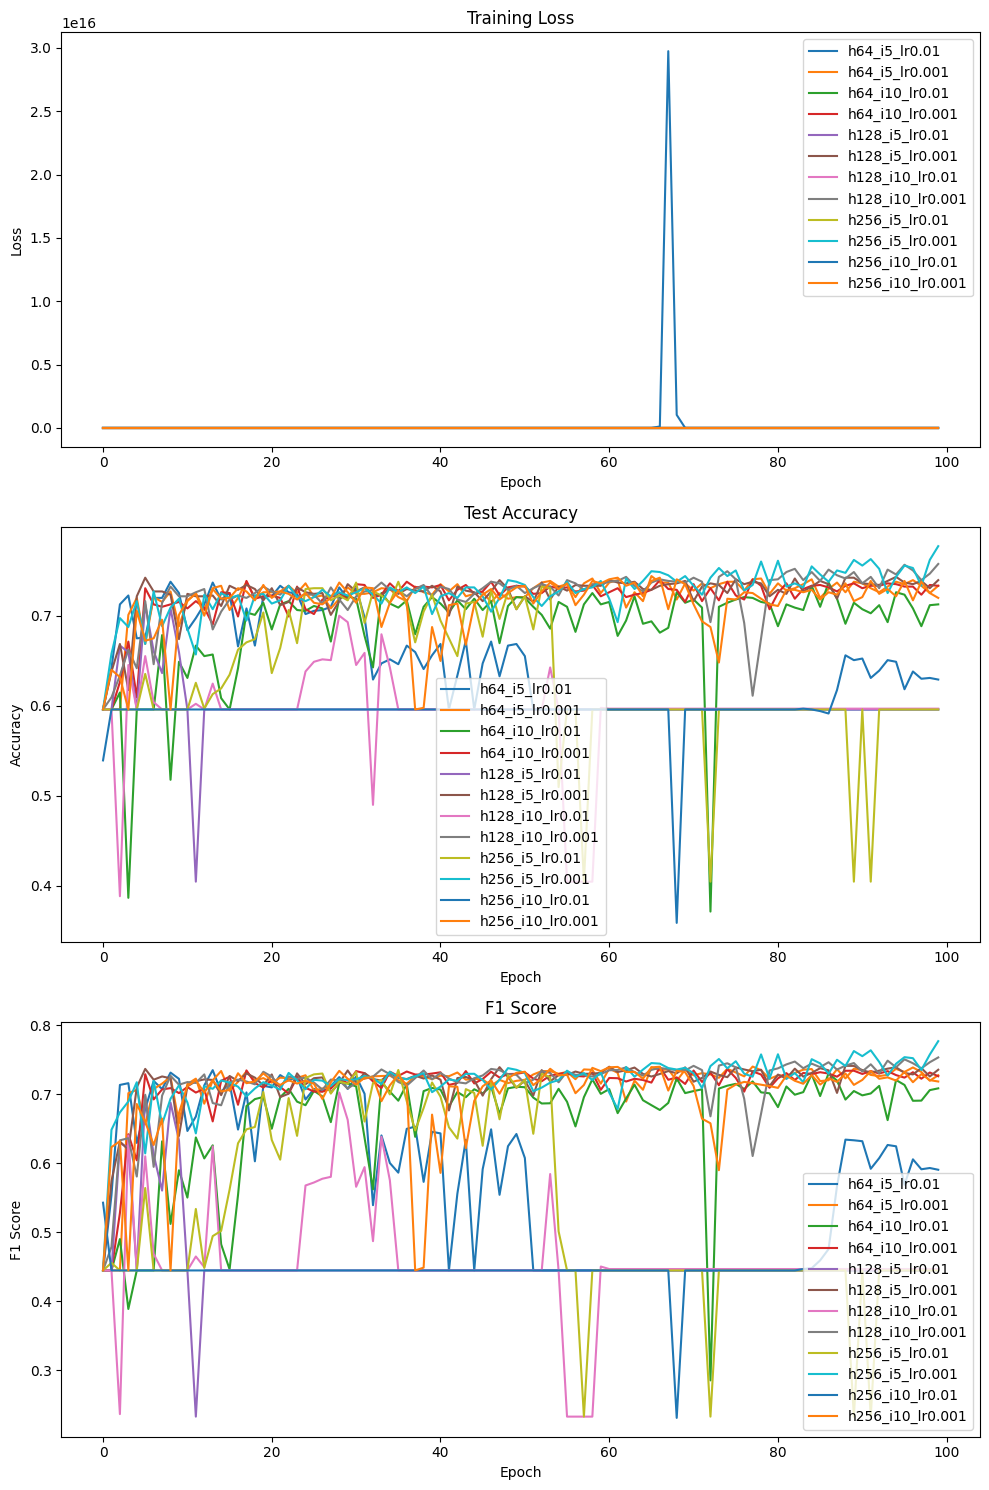

In [24]:
# Function to run multiple experiments and plot results
def compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs):
    results = {}
    for hidden_size in hidden_sizes:
        for num_iterations in num_iterations_list:
            for lr in learning_rates:
                key = f'h{hidden_size}_i{num_iterations}_lr{lr}'
                print(f'Running experiment: {key}')
                train_losses, test_accuracies, f1_scores = run_experiment(hidden_size, num_iterations, lr, num_epochs)
                results[key] = {
                    'train_losses': train_losses,
                    'test_accuracies': test_accuracies,
                    'f1_scores': f1_scores
                }

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for key, data in results.items():
        ax1.plot(data['train_losses'], label=key)
        ax2.plot(data['test_accuracies'], label=key)
        ax3.plot(data['f1_scores'], label=key)

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png')
    plt.show()

    # Save results to a JSON file
    with open('experiment_results.json', 'w') as f:
        json.dump(results, f)

# Run experiments
hidden_sizes = [64, 128, 256]
num_iterations_list = [5, 10]
learning_rates = [0.01, 0.001]
num_epochs = 100

compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs)


In [25]:
!zip -r /content/runs.zip /content/runs


  adding: content/runs/ (stored 0%)
  adding: content/runs/experiment_h128_i5_lr0.01/ (stored 0%)
  adding: content/runs/experiment_h128_i5_lr0.01/events.out.tfevents.1725455969.a877bd2668c5.411.4 (deflated 71%)
  adding: content/runs/experiment_h256_i10_lr0.001/ (stored 0%)
  adding: content/runs/experiment_h256_i10_lr0.001/events.out.tfevents.1725460001.a877bd2668c5.411.11 (deflated 67%)
  adding: content/runs/experiment_h64_i10_lr0.01/ (stored 0%)
  adding: content/runs/experiment_h64_i10_lr0.01/events.out.tfevents.1725455516.a877bd2668c5.411.2 (deflated 68%)
  adding: content/runs/experiment_h128_i10_lr0.001/ (stored 0%)
  adding: content/runs/experiment_h128_i10_lr0.001/events.out.tfevents.1725456987.a877bd2668c5.411.7 (deflated 67%)
  adding: content/runs/experiment_h128_i5_lr0.001/ (stored 0%)
  adding: content/runs/experiment_h128_i5_lr0.001/events.out.tfevents.1725456232.a877bd2668c5.411.5 (deflated 68%)
  adding: content/runs/experiment_h64_i5_lr0.001/ (stored 0%)
  adding: c

In [27]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# To load and plot results later:
# with open('experiment_results.json', 'r') as f:
#     loaded_results = json.load(f)
# Then use the plotting code from compare_hyperparameters to visualize loaded_results



In [29]:
!pip install plotly

In [30]:
import plotly.graph_objects as go

# Sample data representing your training loss, test accuracy, and F1 score for various hyperparameters
# Replace this with your actual data in the same format
epochs = list(range(100))  # Assuming you have 100 epochs

# Dummy results for each hyperparameter combination (replace with actual results)
results = {
    'h64_i5_lr0.01': {
        'train_losses': [0.6 + (i / 1000) for i in epochs],
        'test_accuracies': [0.5 + (i / 1000) for i in epochs],
        'f1_scores': [0.55 + (i / 1000) for i in epochs]
    },
    'h128_i10_lr0.001': {
        'train_losses': [0.55 + (i / 1000) for i in epochs],
        'test_accuracies': [0.55 + (i / 1000) for i in epochs],
        'f1_scores': [0.6 + (i / 1000) for i in epochs]
    },
    # Add other configurations here...
}

# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['train_losses'], mode='lines', name=f'{label} - Train Loss'))

# Plot Test Accuracy
for label, data in results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['test_accuracies'], mode='lines', name=f'{label} - Test Accuracy'))

# Plot F1 Score
for label, data in results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['f1_scores'], mode='lines', name=f'{label} - F1 Score'))

# Customize layout
fig.update_layout(
    title="Training Loss, Test Accuracy, and F1 Score",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",
    legend=dict(yanchor="top", y=1, xanchor="left", x=0, bgcolor='rgba(255, 255, 255, 0.5)', bordercolor="Black", borderwidth=1),
)

# Show the figure
fig.show()


In [28]:
import json

def find_best_hyperparameters(results_file='experiment_results.json'):
    # Load the results from the JSON file
    with open(results_file, 'r') as f:
        results = json.load(f)

    # Initialize variables to store the best results
    best_accuracy = 0
    best_f1_score = 0
    best_accuracy_params = None
    best_f1_params = None

    # Iterate over the results to find the best accuracy and F1 score
    for key, data in results.items():
        # Get the highest accuracy and F1 score from each experiment
        max_accuracy = max(data['test_accuracies'])
        max_f1_score = max(data['f1_scores'])

        # Check if it's the best accuracy so far
        if max_accuracy > best_accuracy:
            best_accuracy = max_accuracy
            best_accuracy_params = key

        # Check if it's the best F1 score so far
        if max_f1_score > best_f1_score:
            best_f1_score = max_f1_score
            best_f1_params = key

    # Print the best results
    print(f"Best Accuracy: {best_accuracy:.4f} with hyperparameters: {best_accuracy_params}")
    print(f"Best F1 Score: {best_f1_score:.4f} with hyperparameters: {best_f1_params}")

# After the experiments are done, call the function to find the best hyperparameters
find_best_hyperparameters()

Best Accuracy: 0.7772 with hyperparameters: h256_i5_lr0.001
Best F1 Score: 0.7772 with hyperparameters: h256_i5_lr0.001
